In [1]:
# Install necessary libraries if you haven't already
# !pip install scanpy pandas matplotlib seaborn scipy

# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io # For reading .mtx files

print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

Scanpy version: 1.11.1
Pandas version: 2.2.3


In [2]:
# --- Load Gene Expression Matrix (.mtx) ---
try:
    # Read the sparse matrix
    matrix_data = scipy.io.mmread('Data_Couturier2020_Brain/Exp_data_TPM.mtx').T.tocsr() # Transpose if genes are rows and cells are columns in .mtx
    print(f"Loaded expression matrix shape: {matrix_data.shape}")
except FileNotFoundError:
    print("Error: Exp_data_TPM.mtx not found. Please ensure the file is in the correct directory.")
    exit() # Stop execution if this critical file is missing

# --- Load Cell Metadata (Cells.csv) ---
try:
    cell_metadata = pd.read_csv('Data_Couturier2020_Brain/Cells.csv', index_col=0) # Assuming 'cell_name' is the first column and acts as index
    print(f"Loaded cell metadata shape: {cell_metadata.shape}")
    print("\nFirst 5 rows of cell metadata:")
    print(cell_metadata.head())
except FileNotFoundError:
    print("Error: Cells.csv not found. Please ensure the file is in the correct directory.")
    exit()

# --- Load Gene Names (Genes.txt) ---
try:
    # Read gene names from Genes.txt, assuming one gene name per line
    with open('Data_Couturier2020_Brain/Genes.txt', 'r') as f:
        gene_names = [line.strip() for line in f if line.strip()] # Read lines and remove empty ones
    print(f"Loaded {len(gene_names)} gene names.")
    print("First 10 gene names:")
    print(gene_names[:10])
except FileNotFoundError:
    print("Error: Genes.txt not found. Please ensure the file is in the correct directory.")
    exit()

# --- Construct the AnnData object ---
# Create AnnData object with the expression matrix
adata = sc.AnnData(matrix_data)

# Assign cell metadata (observations)
# Ensure the index of cell_metadata matches the number of cells in the matrix
if cell_metadata.shape[0] == adata.n_obs:
    adata.obs = cell_metadata
    print("Cell metadata successfully assigned to adata.obs.")
else:
    print("Warning: Number of cells in matrix and metadata do not match.")
    print(f"Matrix cells: {adata.n_obs}, Metadata cells: {cell_metadata.shape[0]}")
    # You might need to align them if they don't match, e.g., using common cell names.
    # For now, we proceed, but be aware of potential issues.

# Assign gene names (variables)
# Ensure the number of gene names matches the number of genes in the matrix
if len(gene_names) == adata.n_vars:
    adata.var_names = gene_names
    print("Gene names successfully assigned to adata.var_names.")
else:
    print("Warning: Number of genes in matrix and gene list do not match.")
    print(f"Matrix genes: {adata.n_vars}, Gene list genes: {len(gene_names)}")
    # If they don't match, you need to troubleshoot your .mtx and .txt files.
    # For now, we proceed, but be aware of potential issues.

# Crucial step: Convert gene names to string type to prevent TypeError
adata.var_names = adata.var_names.astype(str)
print("All gene names converted to string type.")


# Print basic information about the constructed AnnData object
print(f"\nConstructed AnnData object: {adata}")
print(f"Number of cells (observations): {adata.n_obs}")
print(f"Number of genes (variables): {adata.n_vars}")
print(f"Example cell metadata columns: {adata.obs.columns.tolist()}")
print(f"Example gene metadata columns: {adata.var.columns.tolist()}") # Should be empty initially, 'mt' will be added later

Loaded expression matrix shape: (100335, 33694)
Loaded cell metadata shape: (100335, 10)

First 5 rows of cell metadata:
                          sample  cell_type  umap1  umap2  g1s_score  \
cell_name                                                              
AAACCTGAGAAGGTTT-1         BT322        NaN    NaN    NaN        NaN   
AAACCTGAGAGACTTA-1  HFA571_cd133        NaN    NaN    NaN        NaN   
AAACCTGAGCGTTGCC-1         BT322        NaN    NaN    NaN        NaN   
AAACCTGCAACACCTA-1    BT363_1of2  Malignant    NaN    NaN    -0.1877   
AAACCTGGTAAGTGGC-1         BT322        NaN    NaN    NaN        NaN   

                    g2m_score cell_cycle_phase  mp_top_score  \
cell_name                                                      
AAACCTGAGAAGGTTT-1        NaN              NaN           NaN   
AAACCTGAGAGACTTA-1        NaN              NaN           NaN   
AAACCTGAGCGTTGCC-1        NaN              NaN           NaN   
AAACCTGCAACACCTA-1     0.0023      Not cycling        

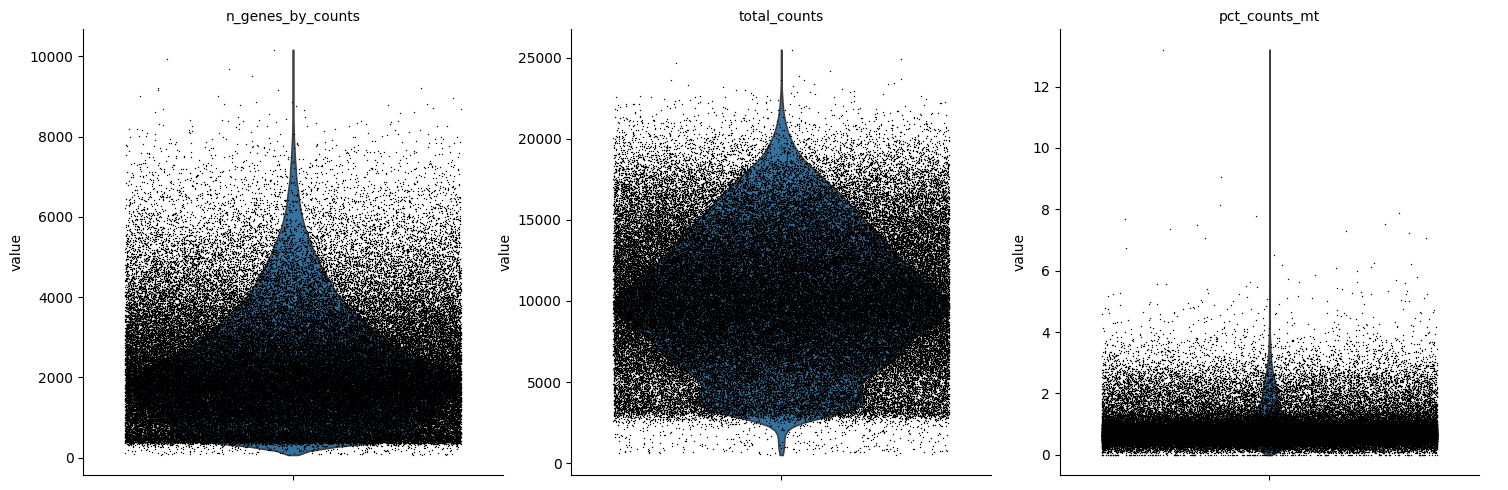

<Figure size 640x480 with 0 Axes>

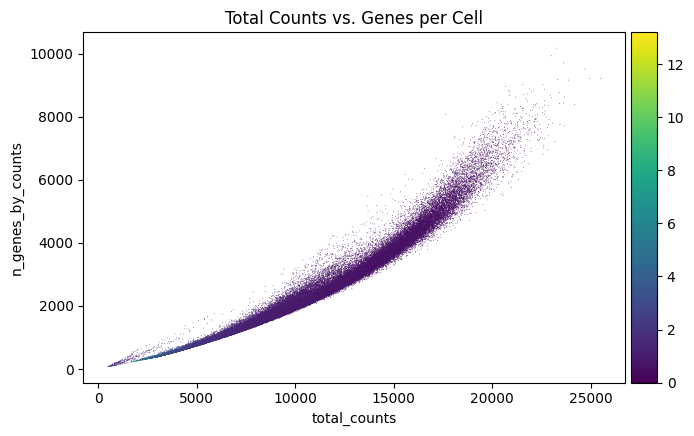


Filtering cells: keeping cells with > 200 genes and < 2500 genes.
Filtering cells: keeping cells with < 5% mitochondrial reads.
Filtering genes: keeping genes expressed in at least 3 cells.


/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number



AnnData object after QC filtering: AnnData object with n_obs × n_vars = 64021 × 25702
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
Number of cells after filtering: 64021
Number of genes after filtering: 25702


In [6]:
# --- Calculate QC metrics ---

# Identify mitochondrial genes (adjust prefix if needed, e.g., 'mt-' for mouse)
# This line should now work correctly as adata.var_names are proper gene names
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot QC metrics to help determine filtering thresholds
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
plt.suptitle('Initial QC Metrics (before filtering)', y=1.02, fontsize=16)
plt.show()

# Visualize scatter plots of QC metrics
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', title='Total Counts vs. Genes per Cell')
plt.show()

# --- Filter cells and genes based on QC metrics ---

# Define filtering thresholds based on the plots above.
# These values are examples and should be adjusted for your specific dataset.
min_genes_per_cell = 200      # Minimum number of genes detected in a cell
max_genes_per_cell = 2500     # Maximum number of genes detected in a cell (to remove potential doublets)
max_pct_counts_mt = 5         # Maximum percentage of mitochondrial reads

min_cells_per_gene = 3        # Minimum number of cells a gene must be expressed in

print(f"\nFiltering cells: keeping cells with > {min_genes_per_cell} genes and < {max_genes_per_cell} genes.")
print(f"Filtering cells: keeping cells with < {max_pct_counts_mt}% mitochondrial reads.")
print(f"Filtering genes: keeping genes expressed in at least {min_cells_per_gene} cells.")

# Filter cells
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell) # Optional: filter out potential doublets
adata = adata[adata.obs.pct_counts_mt < max_pct_counts_mt, :] # Filter based on mitochondrial content

# Filter genes
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)


print(f"\nAnnData object after QC filtering: {adata}")
print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Number of genes after filtering: {adata.n_vars}")

In [7]:
# Normalize counts per cell to 10,000 reads
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

print(f"\nAnnData object after normalization and logarithmization: {adata}")


AnnData object after normalization and logarithmization: AnnData object with n_obs × n_vars = 64021 × 25702
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'


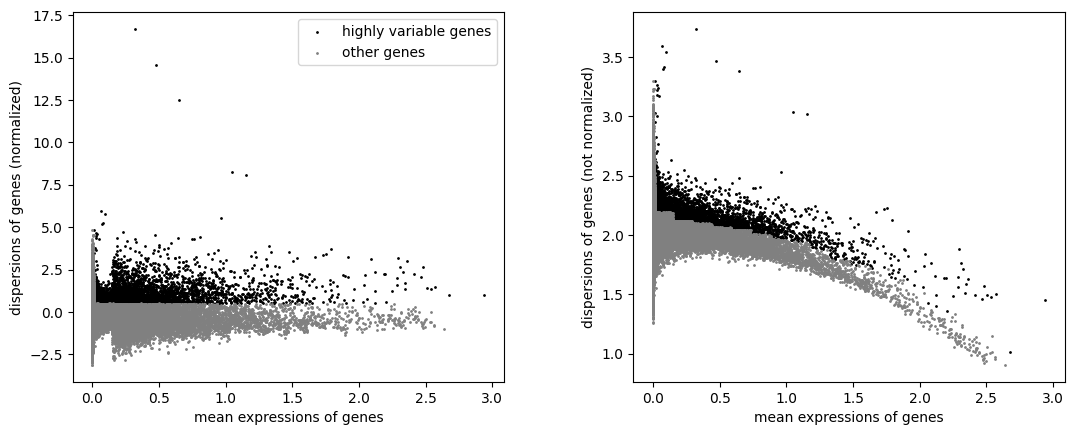


AnnData object after selecting highly variable genes: View of AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Number of highly variable genes: 4211


In [9]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)
plt.show()

# Subset the AnnData object to include only highly variable genes for downstream analysis
adata = adata[:, adata.var.highly_variable]

print(f"\nAnnData object after selecting highly variable genes: {adata}")
print(f"Number of highly variable genes: {adata.n_vars}")


--- Debugging: After sc.pp.scale ---
adata.X is a dense numpy array (type: <class 'numpy.ndarray'>)
Min value in adata.X (scaled): -7.1929
Max value in adata.X (scaled): 10.0000
--- End Debugging: After sc.pp.scale ---

--- Debugging: After sc.tl.pca ---
Shape of adata.obsm['X_pca']: (64021, 50)
Min value in adata.obsm['X_pca']: -25.1676
Max value in adata.obsm['X_pca']: 59.4377
--- End Debugging: After sc.tl.pca ---


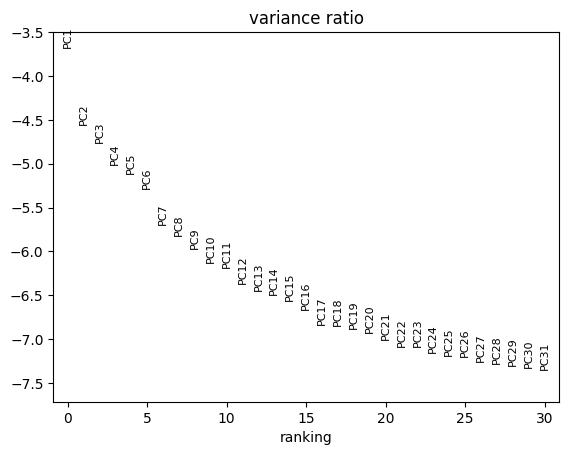


--- Debugging: After sc.pp.neighbors ---
Neighbors graph successfully computed and stored in adata.uns['neighbors'].
Neighbors parameters: {'n_neighbors': 10, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'n_pcs': 40}
--- End Debugging: After sc.pp.neighbors ---

AnnData object after PCA, neighbors graph, and UMAP: AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [30]:
# Scale the data (important before PCA)
# Set max_value to 10 to prevent extreme outliers from dominating
sc.pp.scale(adata, max_value=10)

print("\n--- Debugging: After sc.pp.scale ---")

# Determine if adata.X is a sparse matrix or a dense numpy array
import scipy.sparse # Ensure scipy.sparse is imported for isinstance checks
is_sparse = scipy.sparse.issparse(adata.X) # More robust check for sparse matrices

if is_sparse:
    # Handle sparse matrix
    data_to_check = adata.X.data # Get the non-zero values array
    print(f"adata.X is a sparse matrix (type: {type(adata.X)})")
else:
    # Handle dense numpy array
    data_to_check = adata.X
    print(f"adata.X is a dense numpy array (type: {type(adata.X)})")

# Check for NaN or Inf values in the expression matrix after scaling
if np.isnan(data_to_check).any():
    print(f"WARNING: NaN values found in adata.X after scaling! Count: {np.isnan(data_to_check).sum()}")
if np.isinf(data_to_check).any():
    print(f"WARNING: Inf values found in adata.X after scaling! Count: {np.isinf(data_to_check).sum()}")

# Check the range of scaled data
if data_to_check.size > 0: # Check if there are any elements in the data to check
    min_val = np.min(data_to_check) # Use np.min()
    max_val = np.max(data_to_check) # Use np.max()
    print(f"Min value in adata.X (scaled): {min_val:.4f}")
    print(f"Max value in adata.X (scaled): {max_val:.4f}")
else:
    print("WARNING: adata.X (or its data component) is empty. Cannot check range.")

print("--- End Debugging: After sc.pp.scale ---")

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

print("\n--- Debugging: After sc.tl.pca ---")
# Check if PCA results (X_pca) contain NaN or Inf
if 'X_pca' in adata.obsm:
    if np.isnan(adata.obsm['X_pca']).any():
        print(f"WARNING: NaN values found in adata.obsm['X_pca'] after PCA! Count: {np.isnan(adata.obsm['X_pca']).sum()}")
    if np.isinf(adata.obsm['X_pca']).any():
        print(f"WARNING: Inf values found in adata.obsm['X_pca'] after PCA! Count: {np.isinf(adata.obsm['X_pca']).sum()}")
    
    print(f"Shape of adata.obsm['X_pca']: {adata.obsm['X_pca'].shape}")
    pca_min = adata.obsm['X_pca'].min()
    pca_max = adata.obsm['X_pca'].max()
    print(f"Min value in adata.obsm['X_pca']: {pca_min:.4f}")
    print(f"Max value in adata.obsm['X_pca']: {pca_max:.4f}")
else:
    print("ERROR: adata.obsm['X_pca'] not created after PCA. PCA likely failed.")
print("--- End Debugging: After sc.tl.pca ---")

# Plot the variance explained by each principal component
sc.pl.pca_variance_ratio(adata, log=True)
plt.show()

# Compute a neighborhood graph of cells based on PCA components
# n_neighbors: number of neighbors to consider for each cell
# n_pcs: number of principal components to use
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

print("\n--- Debugging: After sc.pp.neighbors ---")
if 'neighbors' in adata.uns:
    print("Neighbors graph successfully computed and stored in adata.uns['neighbors'].")
    print(f"Neighbors parameters: {adata.uns['neighbors']['params']}")
else:
    print("WARNING: Neighbors graph not found in adata.uns['neighbors'].")
print("--- End Debugging: After sc.pp.neighbors ---")

# Compute UMAP embedding
sc.tl.umap(adata)

print(f"\nAnnData object after PCA, neighbors graph, and UMAP: {adata}")
print(f"UMAP coordinates are stored in adata.obsm['X_umap']")

In [25]:
# Compute UMAP embedding with adjusted min_dist
sc.tl.umap(adata, min_dist=0.3)

print(f"\nAnnData object after PCA, neighbors graph, and UMAP: {adata}")
print(f"UMAP coordinates are stored in adata.obsm['X_umap']")


AnnData object after PCA, neighbors graph, and UMAP: AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
UMAP coordinates are stored in adata.obsm['X_umap']


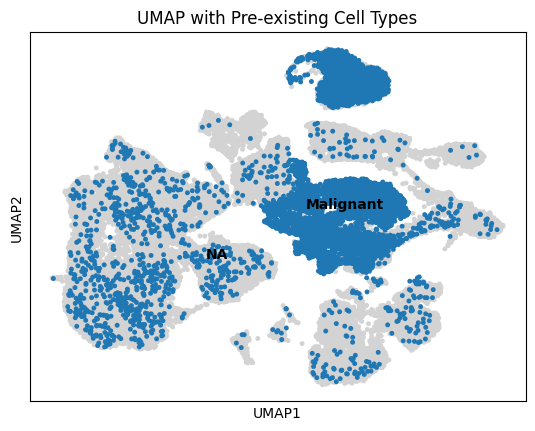

Plotted UMAP with pre-existing cell types.


In [31]:
# --- Option A: Plotting existing UMAP and Cell Type (if available in adata.obs) ---
# Check if 'umap1', 'umap2' are present in adata.obs (they should be from Cells.csv)
if 'umap1' in adata.obs.columns and 'umap2' in adata.obs.columns:
    # Assign existing UMAP coordinates to adata.obsm['X_umap'] for plotting consistency
    # Note: This overwrites UMAP computed in step 6 if you want to use the pre-computed ones.
    # If you want to use scanpy's computed UMAP, skip these two lines.
    # adata.obsm['X_umap'] = adata.obs[['umap1', 'umap2']].values
    # print("Using pre-existing UMAP coordinates from Cells.csv.")

    # Plot existing cell types on UMAP if 'cell_type' is available
    if 'cell_type' in adata.obs.columns:
        sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='UMAP with Pre-existing Cell Types', s=50)
        plt.show()
        print("Plotted UMAP with pre-existing cell types.")
    else:
        print("Warning: 'cell_type' column not found in Cells.csv for plotting.")

# --- Option B: Perform de novo Leiden clustering ---
# Perform Leiden clustering
# resolution: higher values lead to more clusters
# sc.tl.leiden(adata, resolution=0.5)

# # Visualize the UMAP plot colored by newly computed Leiden clusters
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='UMAP with New Leiden Clusters', s=50)
# plt.show()

# print(f"\nAnnData object after Leiden clustering: {adata}")
# print(f"New cluster assignments are stored in adata.obs['leiden']")
# print(f"Number of newly identified clusters: {len(adata.obs['leiden'].unique())}")

In [ ]:
sc.tl.leiden(adata, resolution=0.5)

# # Visualize the UMAP plot colored by newly computed Leiden clusters
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='UMAP with New Leiden Clusters', s=50)
# plt.show()

# print(f"\nAnnData object after Leiden clustering: {adata}")
# print(f"New cluster assignments are stored in adata.obs['leiden']")
# print(f"Number of newly identified clusters: {len(adata.obs['leiden'].unique())}")

In [15]:
print("\n--- Debugging UMAP Plot ---")

# 1. Check number of cells remaining in adata
print(f"Number of cells in adata before plotting: {adata.n_obs}")
if adata.n_obs == 0:
    print("WARNING: No cells remaining in AnnData object. Plot will be empty.")
    # You'll need to go back and adjust your filtering thresholds in QC.

# 2. Check if X_umap exists and its shape
if 'X_umap' in adata.obsm:
    print(f"Shape of adata.obsm['X_umap']: {adata.obsm['X_umap'].shape}")
    # Check for NaN values in UMAP coordinates
    if np.isnan(adata.obsm['X_umap']).any():
        print("WARNING: UMAP coordinates contain NaN values. This can cause an empty plot.")
        print(f"Number of NaN UMAP coordinates: {np.isnan(adata.obsm['X_umap']).sum()}")
    
    # Check the range of UMAP coordinates
    umap_min = adata.obsm['X_umap'].min(axis=0)
    umap_max = adata.obsm['X_umap'].max(axis=0)
    print(f"UMAP1 range: [{umap_min[0]:.2f}, {umap_max[0]:.2f}]")
    print(f"UMAP2 range: [{umap_min[1]:.2f}, {umap_max[1]:.2f}]")
    if (umap_max - umap_min < 1e-6).any(): # Check if range is extremely small
        print("WARNING: UMAP coordinates have an extremely small range, possibly all identical. Plot will be empty or a single point.")
    
    # Print a few example UMAP coordinates
    print("First 5 UMAP coordinates:")
    print(adata.obsm['X_umap'][:5,:])
else:
    print("ERROR: adata.obsm['X_umap'] not found. UMAP computation likely failed in previous step.")

# 3. Check Leiden clustering results (for Option B)
if 'leiden' in adata.obs.columns:
    unique_leiden_clusters = adata.obs['leiden'].astype(str).unique()
    print(f"Unique Leiden clusters: {unique_leiden_clusters.tolist()}")
    print(f"Number of unique Leiden clusters: {len(unique_leiden_clusters)}")
    if len(unique_leiden_clusters) <= 1:
        print("WARNING: Only one or no unique Leiden clusters found. Plotting by cluster will show uniform color.")
else:
    print("WARNING: 'leiden' column not found in adata.obs. Leiden clustering might not have run or failed.")

# 4. Check existing 'cell_type' (for Option A)
if 'cell_type' in adata.obs.columns:
    unique_cell_types = adata.obs['cell_type'].astype(str).unique()
    print(f"Unique cell types: {unique_cell_types.tolist()}")
    print(f"Number of unique cell types: {len(unique_cell_types)}")
else:
    print("INFO: 'cell_type' column not found in adata.obs.")

print("--- End Debugging UMAP Plot ---")

# The original plotting code follows after these checks:
# --- Option A: Plotting existing UMAP and Cell Type (if available in adata.obs) ---
# ... (your existing plotting code) ...


--- Debugging UMAP Plot ---
Number of cells in adata before plotting: 64021
Shape of adata.obsm['X_umap']: (64021, 2)
Number of NaN UMAP coordinates: 128042
UMAP1 range: [nan, nan]
UMAP2 range: [nan, nan]
First 5 UMAP coordinates:
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Unique Leiden clusters: ['3', '2', '6', '4', '0', '7', '1', '8', '12', '9', '14', '16', '10', '11', '18', '5', '15', '17', '13', '19', '20']
Number of unique Leiden clusters: 21
Unique cell types: [np.str_('nan'), 'Malignant']
Number of unique cell types: 2
--- End Debugging UMAP Plot ---



Top 5 marker genes for each Leiden cluster:

Cluster: 0
     genes      scores
0    STMN2  245.025833
1     RTN1  236.099991
2  NEUROD2  220.709534
3     CD24  183.265289
4  NEUROD6  162.538315

Cluster: 1
     genes      scores
0  NEUROD6  219.338058
1     RTN1  205.184189
2    STMN2  184.188843
3   MLLT11  177.154465
4     CD24  173.347733

Cluster: 2
   genes      scores
0    MT3  320.574982
1  CRYAB  274.111511
2   MT2A  265.095459
3   MT1X  227.373871
4   GFAP  218.850021

Cluster: 3
    genes      scores
0  MALAT1  114.141663
1  MT-CO3   88.226662
2  MT-CO1   84.911499
3    NNAT   76.569740
4  TUBA1A   75.090111

Cluster: 4
      genes      scores
0  DLX6-AS1  175.067780
1      SOX4  168.525024
2     STMN2  159.282791
3      RTN1  135.218521
4    TUBB2B  127.583282

Cluster: 5
    genes      scores
0    SPP1  120.318108
1     B2M  114.952888
2    APOE  104.783356
3    MT2A   90.974220
4  SEC61G   90.535103

Cluster: 6
    genes     scores
0    XIST  59.168510
1   NOVA1  55.10696

/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.st

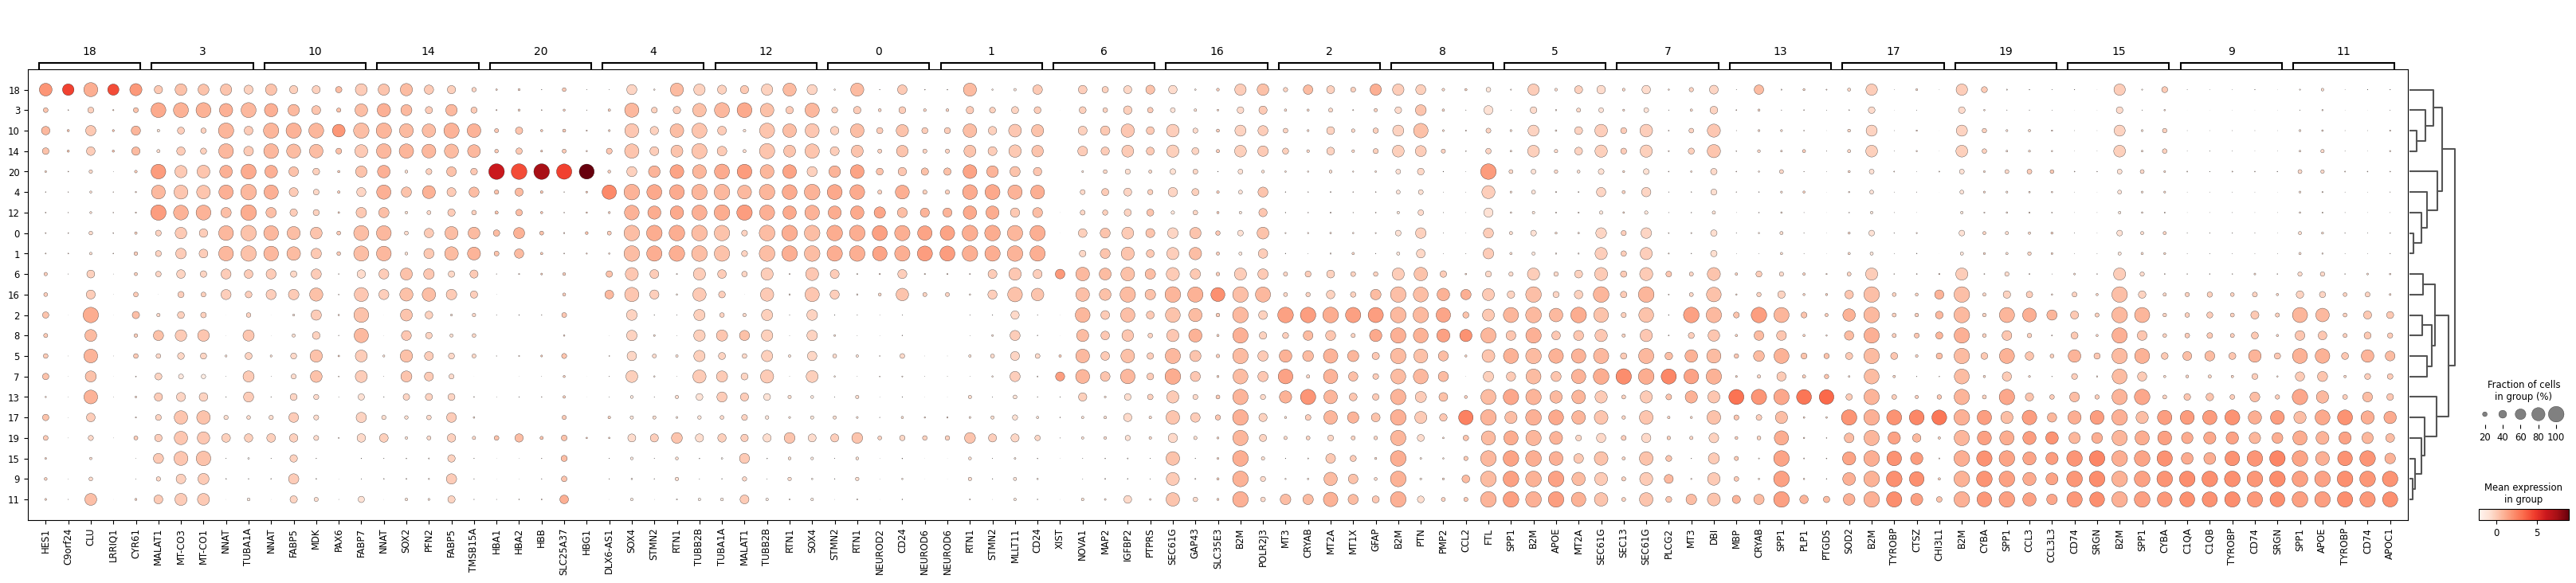

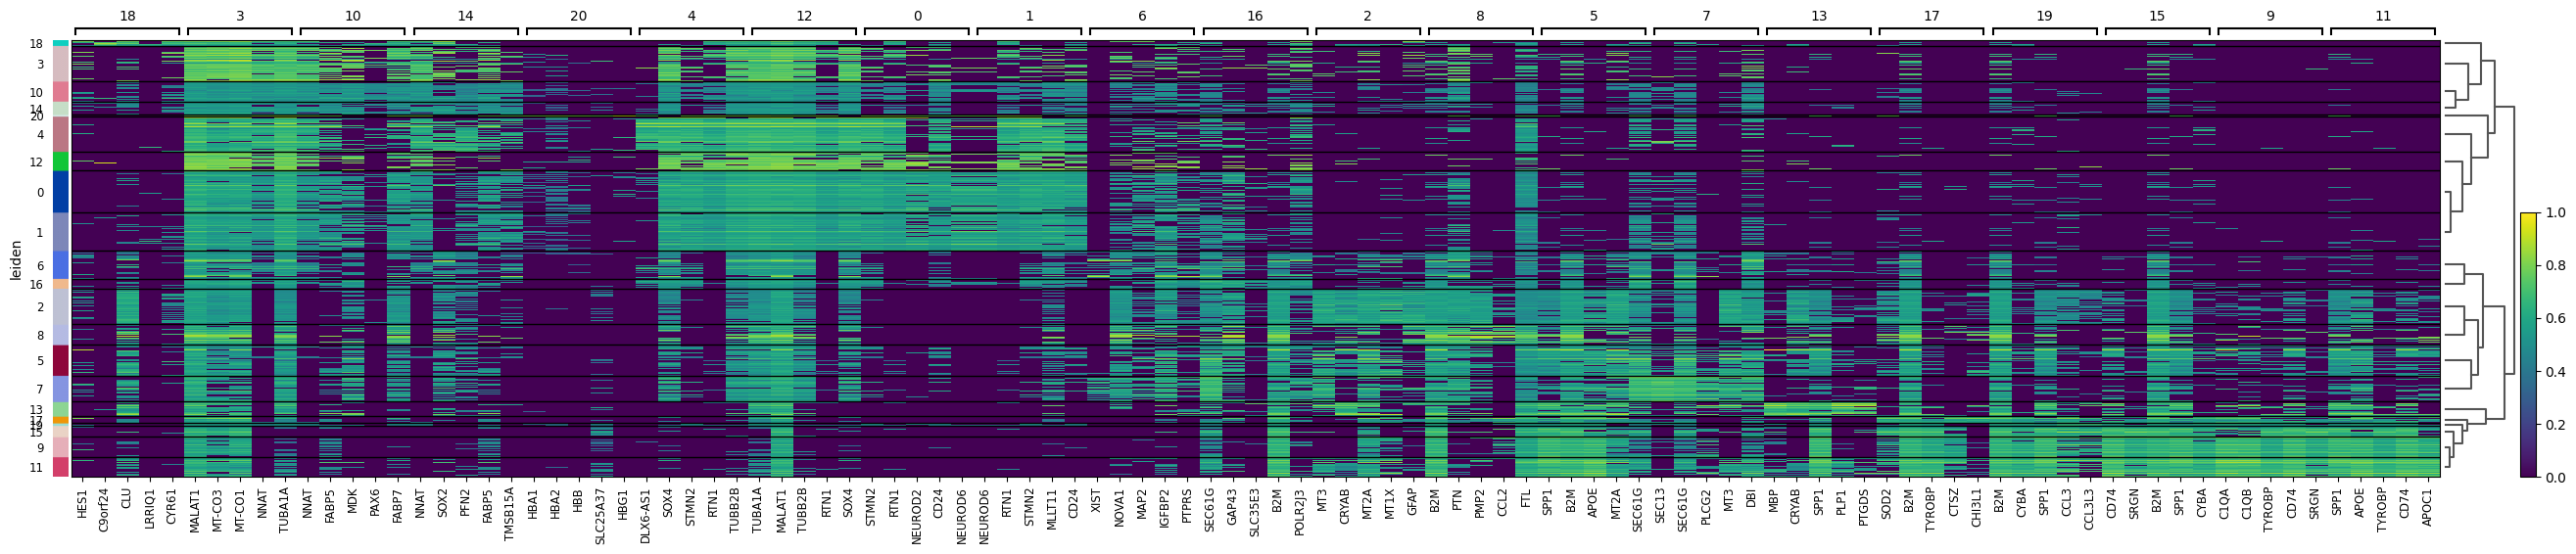

In [13]:
# Identify marker genes for each newly computed Leiden cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Print the top 5 marker genes for each cluster
print("\nTop 5 marker genes for each Leiden cluster:")
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
for group in groups:
    print(f"\nCluster: {group}")
    print(pd.DataFrame({
        'genes': result['names'][group][:5],
        'scores': result['scores'][group][:5]
    }))

# Visualize the top marker genes (e.g., using a dot plot)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='leiden')
plt.show()

# Visualize the top marker genes (e.g., using a heatmap)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', standard_scale='var',
                                show_gene_labels=True, cmap='viridis')
plt.show()

In [14]:
# Save the AnnData object for future use
adata.write('processed_sc_GBM_data.h5ad')
print("\nProcessed AnnData object saved as 'processed_sc_data.h5ad'")

# You can load it back later with:
# adata = sc.read('processed_sc_data.h5ad')


Processed AnnData object saved as 'processed_sc_data.h5ad'


# Read in saved processed data

In [1]:
# Install necessary libraries if you haven't already
# !pip install scanpy pandas matplotlib seaborn scipy

# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io # For reading .mtx files

print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

Scanpy version: 1.11.1
Pandas version: 2.2.3


In [3]:
adata = sc.read('processed_sc_GBM_data.h5ad')


--- Generating Force-Directed Layout Graph ---


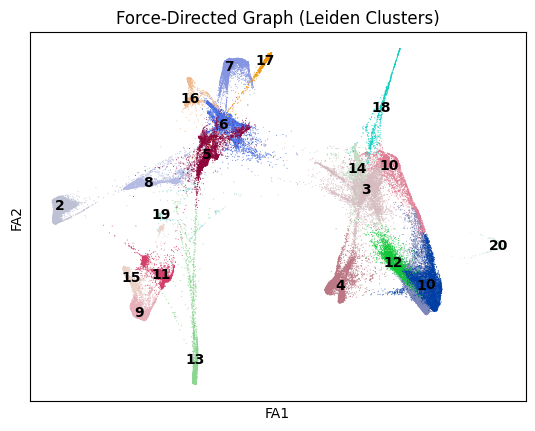

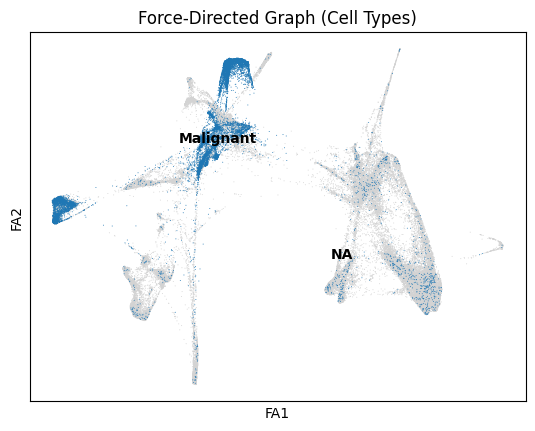

In [6]:
# --- 1. Force-Directed Layout Graph ---
print("\n--- Generating Force-Directed Layout Graph ---")

# Compute a force-directed layout
# This is an alternative to UMAP, often good for revealing detailed local structures.
# It uses the same neighbors graph computed earlier.
sc.tl.draw_graph(adata)

# Plot the force-directed graph, colored by Leiden clusters
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', title='Force-Directed Graph (Leiden Clusters)')
plt.show()

# You can also color it by other metadata, e.g., 'cell_type' from your Cells.csv
if 'cell_type' in adata.obs.columns:
    sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data', title='Force-Directed Graph (Cell Types)')
    plt.show()
else:
    print("Note: 'cell_type' column not found in adata.obs for plotting.")


In [8]:
# Compute UMAP embedding with adjusted min_dist
sc.tl.umap(adata, min_dist=0.3)

print(f"\nAnnData object after PCA, neighbors graph, and UMAP: {adata}")
print(f"UMAP coordinates are stored in adata.obsm['X_umap']")

/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



AnnData object after PCA, neighbors graph, and UMAP: AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
UMAP coordinates are stored in adata.obsm['X_umap']


In [22]:
adata.var_names

Index(['RP4-669L17.10', 'RP11-54O7.1', 'NOC2L', 'HES4', 'AGRN', 'C1orf159',
       'ACAP3', 'CCNL2', 'ATAD3B', 'SLC35E2B',
       ...
       'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5',
       'MT-ND6', 'MT-CYB', 'AC011043.1'],
      dtype='object', length=4211)


--- Visualizing Specific Gene Expression on UMAP ---
Plotting expression for: GFAP, CFAP54, XIST


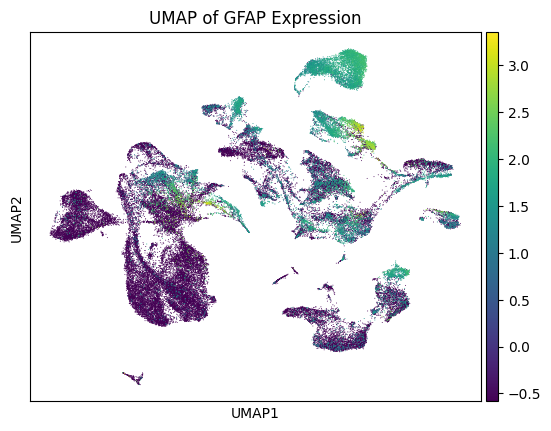

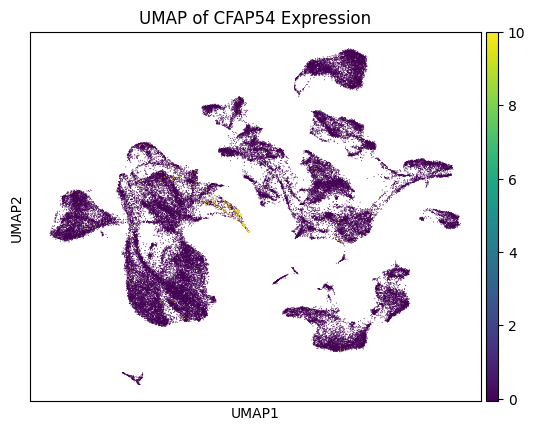

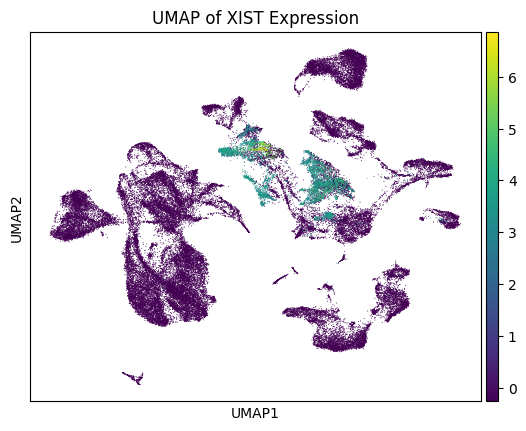


Plotting multiple gene expressions side-by-side on UMAP:


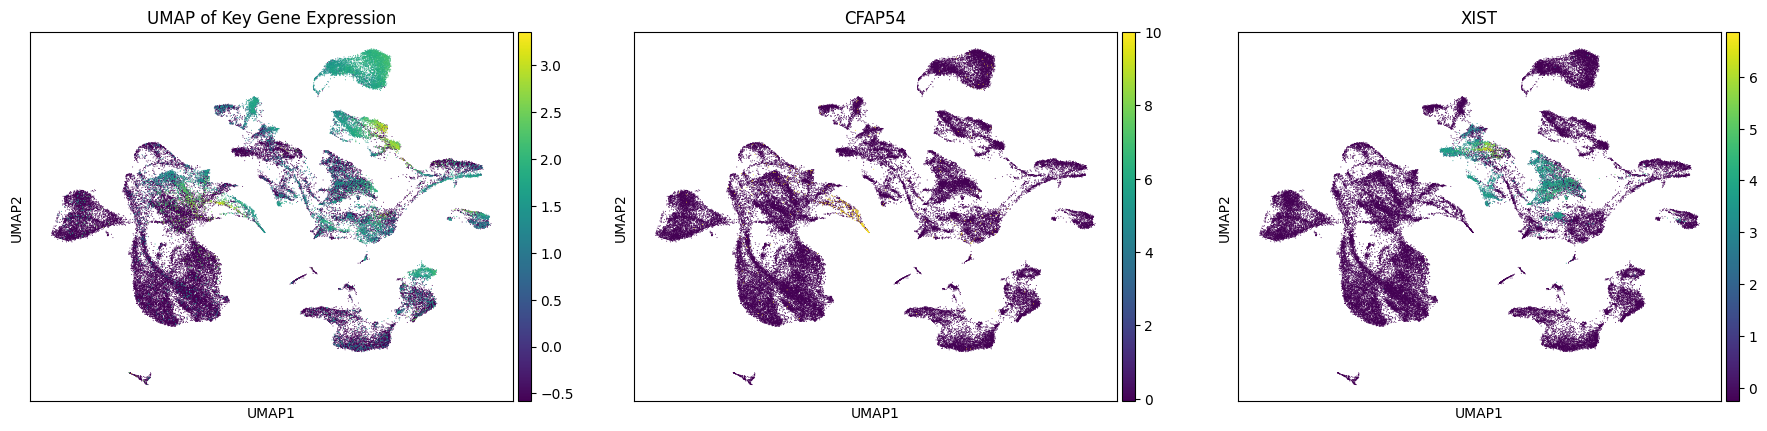


Advanced visualizations complete.


In [26]:
# --- 2. Specific Gene Expression Overlays on UMAP ---
print("\n--- Visualizing Specific Gene Expression on UMAP ---")

# This allows you to see the spatial distribution of gene expression on your UMAP embedding.
# We'll use some of the genes you identified as markers for Cluster 20 (erythroid cells).

# Define a list of genes to plot
# Ensure these genes are present in your adata.var_names
genes_to_plot = ['GFAP', 'CFAP54', 'XIST']

# You can add more genes or choose different ones.
# It's good practice to check if the gene exists in your data first.
# Filter to only include genes actually present in adata.var_names
valid_genes_to_plot = [gene for gene in genes_to_plot if gene in adata.var_names]

if not valid_genes_to_plot:
    print("None of the specified genes found in your dataset. Cannot plot gene expression.")
else:
    print(f"Plotting expression for: {', '.join(valid_genes_to_plot)}")
    # Plot each gene's expression on the UMAP
    for gene in valid_genes_to_plot:
        sc.pl.umap(adata, color=gene, use_raw=False, title=f'UMAP of {gene} Expression', cmap='viridis')
        plt.show()

    # You can also plot multiple genes side-by-side
    print("\nPlotting multiple gene expressions side-by-side on UMAP:")
    sc.pl.umap(adata, color=valid_genes_to_plot, use_raw=False, title='UMAP of Key Gene Expression', cmap='viridis', ncols=len(valid_genes_to_plot))
    plt.show()

print("\nAdvanced visualizations complete.")

Samples Integration

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Load your processed AnnData object
try:
    adata = sc.read('processed_sc_GBM_data.h5ad')
    print("AnnData object loaded successfully.")
    print(adata)
except FileNotFoundError:
    print("Error: processed_sc_data.h5ad not found. Please ensure the file is in the correct directory.")
    exit()

AnnData object loaded successfully.
AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [2]:
# --- 1. Load the samples.csv file ---
try:
    samples_metadata = pd.read_csv('Data_Couturier2020_Brain/Samples.csv', index_col=0) # Assuming first column is sample ID
    print("\nSamples metadata loaded:")
    print(samples_metadata.head())
    print(f"Columns in samples.csv: {samples_metadata.columns.tolist()}")
except FileNotFoundError:
    print("Error: samples.csv not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. Integrate samples_metadata into adata.obs ---
# This is the crucial step. We'll merge based on a common column.
# Your Cells.csv had a 'sample' column, which should be in adata.obs.
# We assume samples.csv also has a 'sample' column (or its index is the sample ID).

# Rename the index of samples_metadata to match the column name in adata.obs for merging
# If samples.csv has a column named 'sample' and that's your key, adjust `on` argument in merge.
# If your samples.csv index contains the 'sample' IDs, then no renaming is needed for index,
# but ensure adata.obs has a matching 'sample' column.

# Let's assume adata.obs has a 'sample' column and samples_metadata.index contains the sample IDs.
if 'sample' in adata.obs.columns:
    print(f"\nMerging samples_metadata into adata.obs using 'sample' column. Example values: {adata.obs['sample'].head().tolist()}")
    
    # Perform the merge.
    # We join adata.obs (left) with samples_metadata (right).
    # left_on='sample' means use the 'sample' column from adata.obs.
    # right_index=True means use the index from samples_metadata.
    # If samples.csv has a column, say 'SampleID_Column', that matches adata.obs['sample'],
    # then use `right_on='SampleID_Column'` instead of `right_index=True`.
    
    # First, make sure the sample column in adata.obs is of string type for robust merging
    adata.obs['sample'] = adata.obs['sample'].astype(str)
    samples_metadata.index = samples_metadata.index.astype(str)

    # Perform the merge
    adata.obs = adata.obs.merge(samples_metadata, left_on='sample', right_index=True, how='left', suffixes=('_cell', '_sample'))

    # Check for NaN values introduced by merge (might happen if some sample IDs don't match)
    if adata.obs.isnull().sum().sum() > 0:
        print("\nWARNING: Some NaN values introduced after merging samples_metadata. Check for unmatched sample IDs.")
        # Example: print(adata.obs[adata.obs['new_sample_column'].isnull()].head())

    print("\nadata.obs after merging:")
    print(adata.obs.head())
    print(f"New columns added to adata.obs: {[col for col in adata.obs.columns if col in samples_metadata.columns.tolist()]}")

else:
    print("WARNING: 'sample' column not found in adata.obs. Cannot merge samples_metadata directly.")
    print("Please inspect your adata.obs columns and samples.csv to find a common identifier.")
    # You might need to manually find the common column and adjust the merge accordingly.



Samples metadata loaded:
          technology  n_cells patient   cancer_type  sex  age  smoking_status  \
sample                                                                          
BT322            10x     3066   BT322  Glioblastoma  NaN  NaN             NaN   
BT324-GSC        10x     5078   BT324  Glioblastoma  NaN  NaN             NaN   
BT326-GSC        10x     2462   BT326  Glioblastoma  NaN  NaN             NaN   
BT333            10x      536   BT333  Glioblastoma  NaN  NaN             NaN   
BT333-GSC        10x     4540   BT333  Glioblastoma  NaN  NaN             NaN   

           PY diagnosis_recurrence disease_extent  ...  targeted_rx_response  \
sample                                             ...                         
BT322     NaN           diagnosis           local  ...            not expsed   
BT324-GSC NaN           diagnosis           local  ...            not expsed   
BT326-GSC NaN           diagnosis           local  ...            not expsed   
BT333 

In [5]:
# Compute UMAP embedding with adjusted min_dist
sc.tl.umap(adata, min_dist=0.3)

print(f"\nAnnData object after PCA, neighbors graph, and UMAP: {adata}")
print(f"UMAP coordinates are stored in adata.obsm['X_umap']")

/opt/anaconda3/envs/sanbomics_scrna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



AnnData object after PCA, neighbors graph, and UMAP: AnnData object with n_obs × n_vars = 64021 × 4211
    obs: 'sample', 'cell_type', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'technology', 'n_cells', 'patient', 'cancer_type', 'sex', 'age', 'smoking_status', 'PY', 'diagnosis_recurrence', 'disease_extent', 'AJCC_T', 'AJCC_N', 'AJCC_M', 'AJCC_stage', 'sample_primary_met', 'size', 'site', 'histology', 'genetic_hormonal_features', 'grade', 'KI67', 'treated_naive', 'chemotherapy_exposed', 'chemotherapy_response', 'targeted_rx_exposed', 'targeted_rx_response', 'ICB_exposed', 'ICB_response', 'ET_exposed', 'ET_response', 'time_end_of_rx_to_sampling', 'post_sampling_rx_exposed', 'post_sampling_rx_response', 'PFS_DFS', 'OS'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_vari


--- Plotting UMAP colored by 'cancer_type' ---


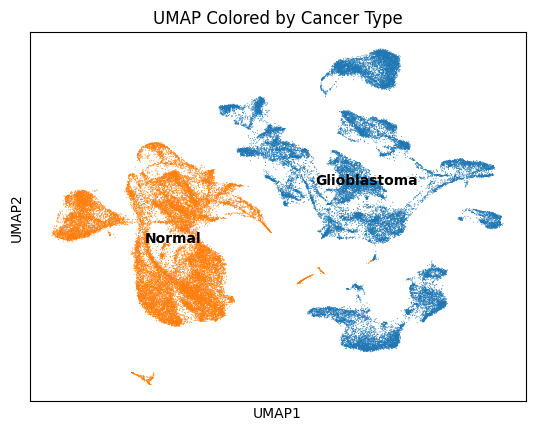


--- Plotting n_genes_by_counts by 'cancer_type' ---


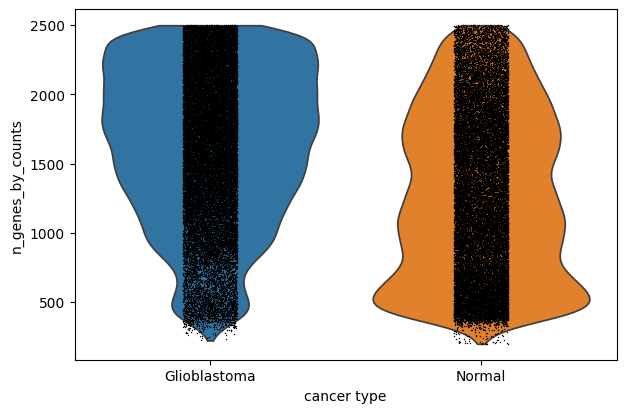


Finished integrating and visualizing samples data.


In [6]:
# --- 3. Visualize using new sample-level metadata ---
# Now you can plot your UMAP using any new column from samples.csv that was added to adata.obs.
# Let's assume samples.csv had a column named 'treatment_group'
# REPLACE 'treatment_group' WITH AN ACTUAL COLUMN NAME FROM YOUR SAMPLES.CSV THAT YOU WANT TO PLOT

plot_column = 'cancer_type' # <--- IMPORTANT: Change this to a column name from your samples.csv

if plot_column in adata.obs.columns:
    print(f"\n--- Plotting UMAP colored by '{plot_column}' ---")
    sc.pl.umap(adata, color=plot_column, title=f'UMAP Colored by {plot_column.replace("_", " ").title()}', legend_loc='on data')
    plt.show()
    
    # You can also use other plotting types, e.g., violin plot for QC metrics per sample group
    if 'n_genes_by_counts' in adata.obs.columns: # Check if QC metrics are still present
        print(f"\n--- Plotting n_genes_by_counts by '{plot_column}' ---")
        sc.pl.violin(adata, keys='n_genes_by_counts', groupby=plot_column)
        plt.show()
else:
    print(f"\nWARNING: Column '{plot_column}' not found in adata.obs after merge. Please check samples.csv columns and merge logic.")

print("\nFinished integrating and visualizing samples data.")


--- Computing and Generating Force-Directed Layout Graph ---


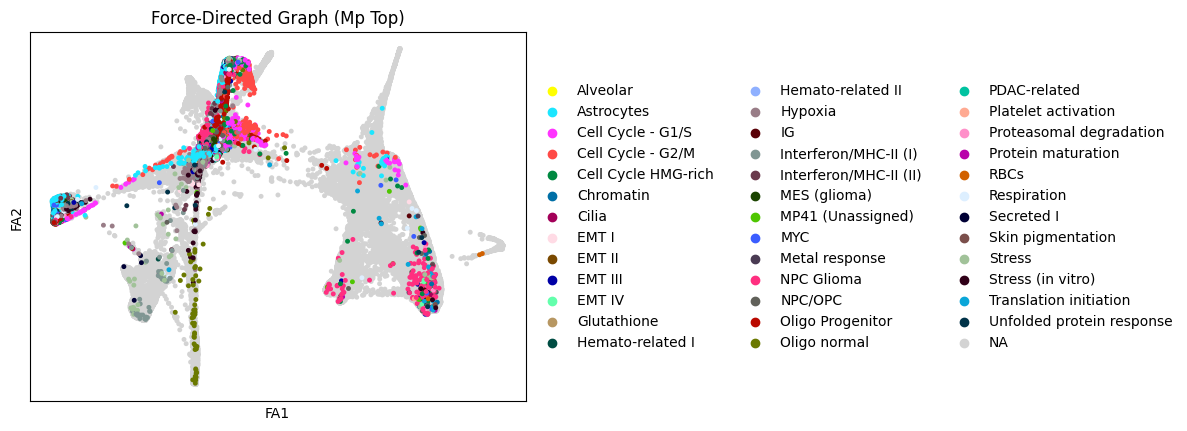


Force-Directed Layout Graph generation complete.


In [8]:
# --- Generate Force-Directed Layout Graph ---
print("\n--- Computing and Generating Force-Directed Layout Graph ---")

# Step 1: Compute a force-directed layout
# This relies on the neighbors graph you already computed (sc.pp.neighbors).
sc.tl.draw_graph(adata)

# Step 2: Plot the force-directed graph
# You can color the graph by any metadata stored in adata.obs (e.g., 'leiden', 'cell_type', 'sample').

# Example 1: Color by Leiden clusters
# sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', title='Force-Directed Graph (Leiden Clusters)', s=50)
# plt.show()

# # Example 2: If you have 'cell_type' annotations (from your Cells.csv)
# if 'cell_type' in adata.obs.columns:
#     sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data', title='Force-Directed Graph (Cell Types)', s=50)
#     plt.show()
# else:
#     print("Note: 'cell_type' column not found in adata.obs for plotting.")

# Example 3: If you have integrated sample information (e.g., 'treatment_group')
# Remember to replace 'treatment_group' with the actual column name from your samples.csv
plot_by_sample_column = 'mp_top' 
if plot_by_sample_column in adata.obs.columns:
    sc.pl.draw_graph(adata, color=plot_by_sample_column, title=f'Force-Directed Graph ({plot_by_sample_column.replace("_", " ").title()})', s=50)
    plt.show()
else:
    print(f"Note: Column '{plot_by_sample_column}' not found in adata.obs for plotting.")

print("\nForce-Directed Layout Graph generation complete.")